# True Reach Estimator

***

We are looking to build an estimator around instagram users true reach and impressions. This data is accessible through the business api but in Q1 2018 Instagram blocked influencer marketing teams from this endpoint. We are able to collect a sample of this data to see if there working correlations between currently public data and true reach/impressions. 

Data: the CSV we have contains one year worth of data from 5,000 influencer level Instagram users. 

## The goal: 
Given the public data points create an accurate estimate of each posts reach and impressions. The ideal would be as accurate as possible, but a 10% range will work for the business. 

# Group 1 - Followers = 1-5K

After many trials we have settled on a 3 variable regression model that uses comments, likes and followers to predict our final reach estimate. 

In order to fit the model most accurately to a normal situation we had to remove special outliers. Instagram's algorithm produces larger variance in individual results. These results had a detremental effect on any prediction results. Eliminating outliers of a single large or small variable has a negative effect on our model as our users vary greatly. However, we determined that issues arose when the ratio of certain variables violated normality. As such, we chose to eliminate the upper and lower 10% of the offending ratios to help fit the model.

For this group we have only included users with followers from 1 to 10,000 to better match the reactions to posts. 

Process:

- work with users that have  0-5k followers.
- Change the confidence interval to 10% or 90%.

- Import the data
- Split the data into a test and training set
- Set conditions on the training data to eliminate outliers
- Create a regression model on our variables to determine the effectiveness of the data so far 
- Use the regression model to check for accuracy in the perdiction across the dataset
- Summarize our findings and suggest next steps if unsucessful

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline
import warnings 
warnings.filterwarnings('ignore')

Pull in the CSV file

In [2]:
df = pd.read_csv('Impression-estimator-data.csv')

Add column labels

In [3]:
df.columns = ['user_id', 'instagram_id', 'followers', 'published', 'likes', 'comments', 'impressions', 'reach', 'saves']

First, look at the data

In [4]:
len(df)

728018

Drop columns that are unneeded.

In [5]:
df2 = df.drop(['user_id', 'instagram_id', 'saves'], axis=1)

**First Data Clean**

Anyone with very little reach will skew the data. It's probably a bot. Lets remove all rows where the reach is less than 300.

In [6]:
df2 = df2.loc[(df2['reach']>1)] #& (df2['reach']<200000)
len(df2)

727924

### Set bin for follower count
Next we decided to remove rows that have less than 1000 followers. This not only helps eliminate outliers but in the data collection there were many rows with exactly zero followers yet high numbers in reach. This data clearly is not correct or not in the style we are looking for. 

In [7]:
df2 = df2.loc[(df2['followers']>1000) & (df2['followers']<5000)]
len(df2)

94398

In [8]:
df2 = df2.loc[(df2['followers']>1)]

Setting comments to greater than zero to avoid zero division errors

In [9]:
df2 = df2.loc[(df2['comments']>=1)] # & (df2['comments']<=2000)
len(df2)

88591

Remove rows with less than 100 likes to eliminate outliers.

In [10]:
df2 = df2.loc[(df2['likes']>=1)]
len(df2)

88591

Remove wierd situations where there are more comments or likes than reach.

In [11]:
df2 = df2.loc[(df2.likes<df2.reach)]
df2 = df2.loc[(df2.comments<df2.reach)]
len(df2)

87345

## Split the data sets into two - a test and a training data set: 

In [12]:
from sklearn.model_selection import train_test_split
df2, test = train_test_split(df2, test_size=0.2)

---

# Eliminate the data with *RATIOS* outside of the norm. 

## Step 1 - Add ratio colums onto the data frame

In [13]:
df2['reach_/_followers'] = df2['reach']/df2['followers']

In [14]:
df2['reach_/_likes'] = df2['reach']/df2['likes']

In [15]:
df2['reach_/_comments'] = df2['reach']/df2['comments']

#### Look at the distribution of those ratio without manipulation

(-0.0004, 1000)

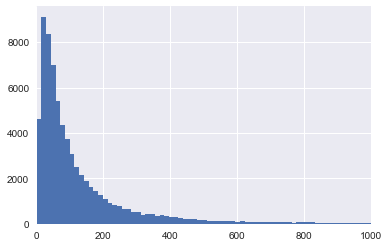

In [16]:
plt.hist(df2['reach_/_comments'], bins=1000)
plt.xlim(-.0004,1000)

(-0.03, 3)

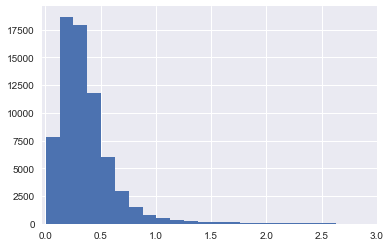

In [17]:
plt.hist(df2['reach_/_followers'], bins=1000)
plt.xlim(-.03,3)

(-0.003, 30)

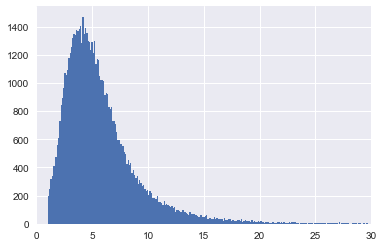

In [18]:
plt.hist(df2['reach_/_likes'], bins=1000)
plt.xlim(-.003, 30)

## Step 2 - Set confidence intervals for each ration

 *Just checking what some filters would look like without finding a confidence interval.* 

In [19]:
len(df2[(df2['reach_/_followers'] < df2['reach_/_followers'].quantile(.05))])

3494

In [20]:
len(df2[(df2['reach_/_followers'] > df2['reach_/_followers'].quantile(.95))])

3494

In [21]:
len(df2[(df2['reach_/_likes'] > df2['reach_/_likes'].quantile(.95))])

3494

In [22]:
len(df2[(df2['reach_/_likes'] < df2['reach_/_likes'].quantile(.05))])

3494

In [23]:
len(df2[(df2['reach_/_comments'] < df2['reach_/_comments'].quantile(.05))])

3492

In [24]:
len(df2[(df2['reach_/_comments'] > df2['reach_/_comments'].quantile(.95))])

3488

In [25]:
df2= df2.loc[(df2['reach_/_followers'] > df2['reach_/_followers'].quantile(.1))]
df2= df2.loc[(df2['reach_/_likes'] > df2['reach_/_likes'].quantile(.1))]
df2= df2.loc[(df2['reach_/_comments'] > df2['reach_/_comments'].quantile(.1))]

df2= df2.loc[(df2['reach_/_followers'] < df2['reach_/_followers'].quantile(.9))]
df2= df2.loc[(df2['reach_/_likes'] < df2['reach_/_likes'].quantile(.9))]
df2= df2.loc[(df2['reach_/_comments'] < df2['reach_/_comments'].quantile(.9))]

In [26]:
len(df2)

37114

Now, what does our data look like? 

(20, 320)

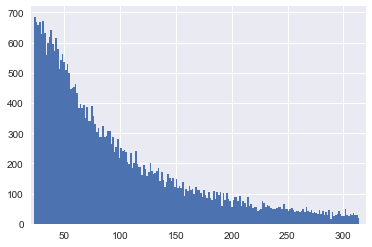

In [27]:
plt.hist(df2['reach_/_comments'], bins=200)
plt.xlim(20, 320)

(2.5, 11)

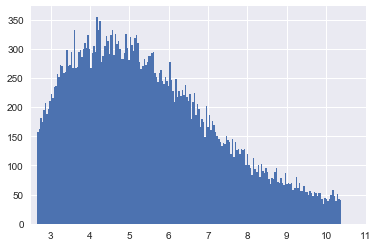

In [28]:
plt.hist(df2['reach_/_likes'], bins=200)
plt.xlim(2.5, 11)

(0.09, 0.75)

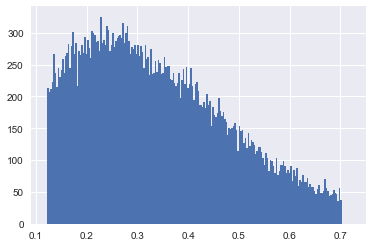

In [29]:
plt.hist(df2['reach_/_followers'], bins=200)
plt.xlim(.09, .75)

# Fit the model

In [30]:
lr_model = ols(formula='reach~followers + likes + comments', data=df2).fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  reach   R-squared:                       0.734
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                 3.413e+04
Date:                Thu, 07 Mar 2019   Prob (F-statistic):               0.00
Time:                        20:06:55   Log-Likelihood:            -2.5904e+05
No. Observations:               37114   AIC:                         5.181e+05
Df Residuals:                   37110   BIC:                         5.181e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     44.8507      3.586     12.508      0.000      37.823      51.879
followers      0.1178      0.001     80.594      0.000       0.115       0.121
likes          2.5988      0.016    163.050      0.000       2.568       2.630
comments       4.6977      0.137     34.283      0.000       4.429       4.966
==============================================================================
Omnibus:                     6960.654   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18425.025
Skew:                           1.021   Prob(JB):                         0.00
Kurtosis:                       5.784   Cond. No.                     7.60e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.6e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Scatterplots 
- Next we look at scatter plots of our data to further look for outliers and the correlation of our independent variable to our dependent variable. 

Text(0.5, 1.0, 'Followers Correlation plot')

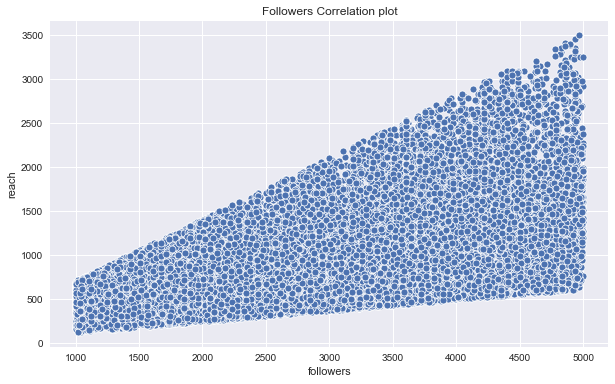

In [31]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=df2.followers, y=df2.reach)
plt.xlabel('followers')
plt.ylabel('reach')
plt.title("Followers Correlation plot")

Text(0.5, 1.0, 'Likes Correlation plot')

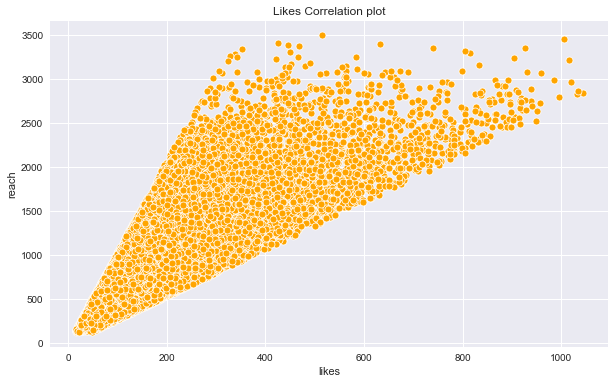

In [32]:
plt.figure(figsize=(10,6))
sns.scatterplot(y=df2.reach, x=df2.likes, color='orange' )
plt.xlabel('likes')
plt.ylabel('reach')
plt.title("Likes Correlation plot")

Text(0.5, 1.0, ' Comments Correlation plot')

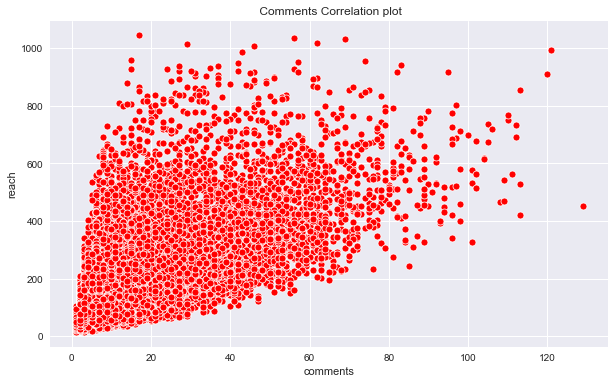

In [33]:
plt.figure(figsize=(10,6))
sns.scatterplot(y=df2.likes, x=df2.comments, color='red')
plt.xlabel('comments')
plt.ylabel('reach')
plt.title(" Comments Correlation plot")

Further we used Statsmodels to create an OLS model. This allows us to see all the import statistics and values associated with the three variables together. 

In [34]:
lr_model = ols(formula='reach~followers+likes+comments', data=df2).fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  reach   R-squared:                       0.734
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                 3.413e+04
Date:                Thu, 07 Mar 2019   Prob (F-statistic):               0.00
Time:                        20:06:57   Log-Likelihood:            -2.5904e+05
No. Observations:               37114   AIC:                         5.181e+05
Df Residuals:                   37110   BIC:                         5.181e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     44.8507      3.586     12.508      0.000      37.823      51.879
followers      0.1178      0.001     80.594      0.000       0.115       0.121
likes          2.5988      0.016    163.050      0.000       2.568       2.630
comments       4.6977      0.137     34.283      0.000       4.429       4.966
==============================================================================
Omnibus:                     6960.654   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18425.025
Skew:                           1.021   Prob(JB):                         0.00
Kurtosis:                       5.784   Cond. No.                     7.60e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.6e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Test the Model

Create a quick function to run the coefficients from the three variables. 

### Add Test Reach to the original data Frame to check for accuracy

In [35]:
test['test_reach'] = round(lr_model.predict(test),1)

In [36]:
test['reach_diff'] = round(test['reach'] - test['test_reach'],1)

In [37]:
test.head()

,followers,published,likes,comments,impressions,reach,test_reach,reach_diff
665642,1758,2018-03-05T20:05:18.000+00:00,147,3,333,312,648.1,-336.1
191044,2500,2017-11-23T01:01:40.000+00:00,112,10,333,253,677.5,-424.5
363923,1711,2018-02-03T19:44:55.000+00:00,399,5,1847,1531,1306.9,224.1
673874,1643,2018-06-20T15:57:51.000+00:00,395,24,1557,1026,1377.7,-351.7
367821,2678,2018-06-07T01:58:57.000+00:00,186,10,2458,1855,890.8,964.2


In [38]:
test['diff_ratio'] = round((test.reach_diff / test.reach)*100, 1)

(-300, 300)

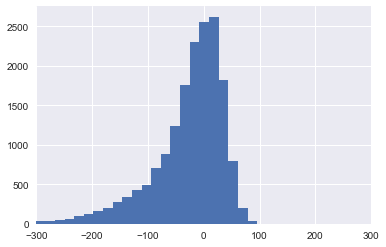

In [39]:
x = plt.hist(test.diff_ratio, bins = 100)
plt.xlim(-300, 300)

In [40]:
mean_squared_error(test.reach, test.test_reach)**.5

1335.7757300366084

## Interactions.
Lets create a plot to see if the three variables are interacting with each other in the model. 

In [41]:
from sklearn.linear_model import LinearRegression
regression_1 = LinearRegression()
regression_2 = LinearRegression()
regression_3 = LinearRegression()

likes = df2["likes"].values.reshape(-1, 1)
comments = df2["comments"].values.reshape(-1, 1)
followers = df2["followers"].values.reshape(-1, 1)

regression_1.fit(likes, df2["reach"])
regression_2.fit(comments, df2["reach"])
regression_3.fit(followers, df2["reach"])

# Make predictions using the testing set
pred_1 = regression_1.predict(likes)
pred_2 = regression_2.predict(comments)
pred_3 = regression_3.predict(followers)

# The coefficients
print(regression_1.coef_)
print(regression_2.coef_)
print(regression_3.coef_)

[3.47395127]
[23.98088934]
[0.28676231]


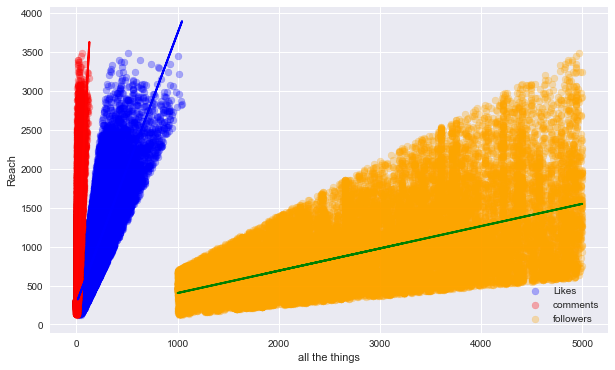

In [42]:
# Plot outputs
plt.figure(figsize=(10,6))

plt.scatter(likes, df2["reach"],  color='blue', alpha = 0.3, label = "Likes")
plt.scatter(comments, df2["reach"],  color='red', alpha = 0.3, label = "comments")
plt.scatter(followers, df2["reach"],  color='orange', alpha = 0.3, label = "followers")

plt.plot(likes, pred_1,  color='blue', linewidth=2)
plt.plot(comments, pred_2,  color='red', linewidth=2)
plt.plot(followers, pred_3,  color='green', linewidth=2)
plt.ylabel("Reach")
plt.xlabel("all the things")
plt.legend();

## Summary of users with 1 - 5,000 followers

This test has produced decent results given many of the outliers were removed to better fit the model.  The model has an r-squared at .73 which indicates that the model explains 73% the variability of the response data around its mean.

Once outlier data is present, as in our test data set, our prediction accuracy is not great.  However, given that we determined our data contains outliers dependent on outside/unknown varialbles (Instagrams algorithm) we can assume that when this prediction model is needed that a human looking to use it will be as critical of the data going in. 